ABHAY SAXENA

2nd Year IISER Kolkata

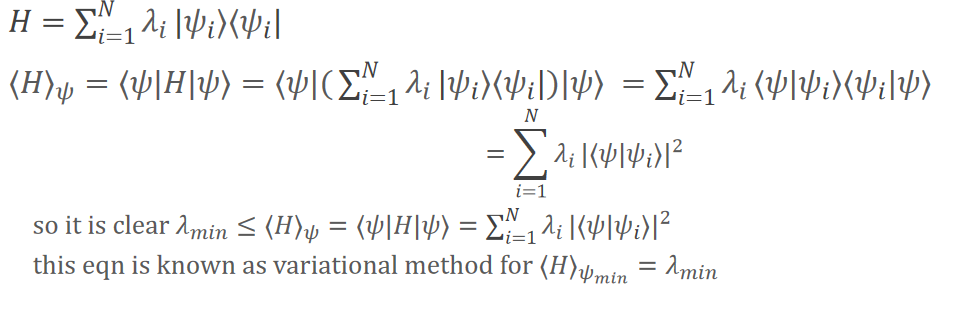

In [35]:
import qiskit_nature
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.drivers import Psi4Driver
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.mappers import ParityMapper
qiskit_nature.settings.use_pauli_sum_op = False

mol = MoleculeInfo(
    # Coordinates in Angstrom
    symbols=["H", "H"],
    coords=([0.0, 0.0, -0.3625], [0.0, 0.0, 0.3625]),
    multiplicity=1,
    charge=0,
)

prob_unmod = Psi4Driver.from_molecule(mol).run()

problem = FreezeCoreTransformer(
        freeze_core=True, remove_orbitals=[-3, -2]
    ).transform(prob_unmod)

num_spatial_orbitals = problem.num_spatial_orbitals
num_particles = problem.num_particles

mapper = ParityMapper(num_particles=num_particles)  # Set Mapper

hamiltonian = mapper.map(problem.second_q_ops()[0])  # Set Hamiltonian

print(hamiltonian)

SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ', 'XX'],
              coeffs=[-1.05016043+0.j,  0.40421466+0.j, -0.40421466+0.j, -0.01134688+0.j,
  0.18037525+0.j])


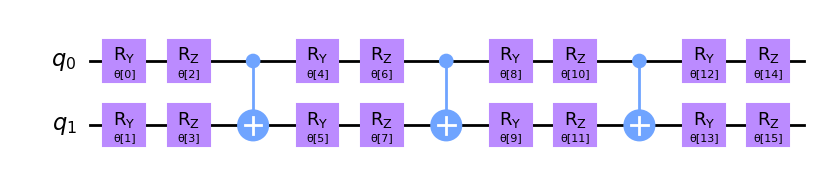

In [36]:
from qiskit.circuit.library import EfficientSU2
#ansatz = TwoLocal(rotation_blocks=['ry', 'rz'], entanglement_blocks='cz')
ansatz = EfficientSU2(hamiltonian.num_qubits)

from qiskit.algorithms.optimizers import SLSQP
optimizer = SLSQP(maxiter=150, max_evals_grouped = 1)

ansatz.decompose().draw('mpl')

Minimize a scalar function of one or more variables using Sequential Least Squares Programming (SLSQP).

The algorithm described is applied to a Lagrange function consisting of loss function and equality- and inequality constraints. Because at each iteration some of the inequality constraints are active, some not, the inactive inequalities are omitted for the next iteration. An equality constrained problem is solved at each step using the active subset of constraints in the Lagrange function.

In [37]:
from qiskit.primitives import Estimator

estimator = Estimator()

In [38]:
counts = []
values = []
steps = []

def callback(eval_count, params, value, meta):
    counts.append(eval_count)
    values.append(value)

<img src=images/vqe_cost.png>

In [39]:
from qiskit.algorithms.minimum_eigensolvers import VQE


vqe = VQE(estimator, ansatz, optimizer, callback=callback)
result = vqe.compute_minimum_eigenvalue(operator = hamiltonian)
vqe_values = result.eigenvalue

In [40]:
print(vqe_values.real)

-1.867120946524108


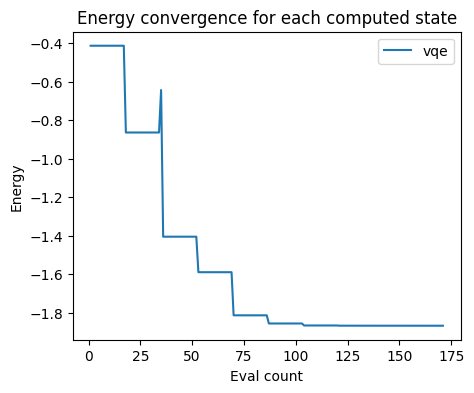

In [41]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (5, 4)

counts = np.asarray(counts)
values = np.asarray(values)
ecp = plt
ecp.plot(counts, values, label="vqe")
ecp.xlabel("Eval count")
ecp.ylabel("Energy")
ecp.title("Energy convergence for each computed state")
ecp.legend(loc="upper right")

In [42]:
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver


exact_solver = NumPyMinimumEigensolver()
exact_result = exact_solver.compute_minimum_eigenvalue(hamiltonian)
ref_values = exact_result.eigenvalue

In [43]:
print(f"Reference values: {ref_values}")
print(f"VQD values: {vqe_values.real}")

Reference values: -1.8671209780023936
VQD values: -1.867120946524108


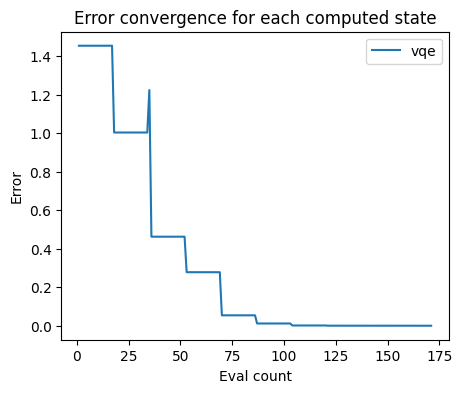

In [44]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (5, 4)

count = np.asarray(counts)
value = -(-np.asarray(values) + ref_values)
ercp = plt
ercp.plot(count, value, label="vqe")
ercp.xlabel("Eval count")
ercp.ylabel("Error")
ercp.title("Error convergence for each computed state")
ercp.legend(loc="upper right")